---

# 1-Introduction

> Name: Bayu Pramana Putra

> Dataset : Fake News Content Detection
- Text : Raw content from social media/ new platforms
- Text_Tag : Different types of content tags (9 unique products)
- Labels : Represents various classes of Labels

> Objectives :
- Using NLP, Sentiment Analysis
- Feature extraction from raw text using TF-IDF, CountVectorizer
- Using Word Embedding to represent words as vectors
- Using Pretrained models like Transformers, BERT
- Optimizing multi-class log loss to generalize well on unseen data
- Analyze and explain the layer made in Neural Network
- Predict whether the news is telling the truth or not, or somewhere in between

---

# 2-Import Libraries

In [317]:
import pandas as pd
import numpy as np
import pickle
import nltk
import wordcloud
import string
import re
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Dropout, GRU

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [2]:
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")
plt.style.use('classic')
warna = sns.color_palette('husl')
warna2 = sns.color_palette('Set2')

---

# 3-Data Loading

In [3]:
df00 = pd.read_csv('train.csv')

In [4]:
df00.sample(10)

Labels                                               Text  \
7597       3  Thirty-one percent of school districts are sti...   
8122       1  Health care premiums up 90 percent in New Hamp...   
8809       5  Taxpayers pay $18,000 a month for House Speake...   
1021       1  When his grandfather arrived in the United Sta...   
8002       3  Medicare Part D was far more expensive than th...   
7234       0  Democrats very much are in the pocket of the NRA.   
7251       0  Harry Reid voted to use taxpayer dollars to pa...   
2691       3  Says(President) Reagans second inaugural was m...   
2973       4  Justice John Roberts Signed Off On Obamas Arre...   
484        4  An independent payment advisory board created ...   

                                               Text_Tag  
7597              education,state-budget,state-finances  
8122                                        health-care  
8809       economy,federal-budget,message-machine,taxes  
1021                                            welfare  
8002                congress,federal-budget,health-care  
7234                              campaign-finance,guns  
7251   crime,federal-budget,health-care,message-machine  
2691                                    history,weather  
2973                      criminal-justice,legal-issues  
484   government-regulation,health-care,message-mach...

---

# 4-Exploratory Data Analysis (EDA)

> EDA Part 1

Create a copy of the original data, so we wont have any worry about changing the original data, so that we can access it anytime when we need to.

In [5]:
df0 = df00.copy()

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Labels    10240 non-null  int64 
 1   Text      10240 non-null  object
 2   Text_Tag  10238 non-null  object
dtypes: int64(1), object(2)
memory usage: 240.1+ KB


In [7]:
df0[df0.Text.duplicated()]

Labels                                               Text  \
1014       2                                        On abortion   
1814       1                       On support for gay marriage.   
1846       1  Obama says Iran is a 'tiny' country, 'doesn't ...   
2697       1                    On repealing the 17th Amendment   
2846       3  Four balanced budgets in a row, with no new ta...   
3256       1                           On a cap-and-trade plan.   
4386       1                  On the Trans-Pacific Partnership.   
4839       2  During Sherrod Browns past decade as a D.C. po...   
4940       1  On changing the rules for filibusters on presi...   
6759       2                                        On torture.   
6784       1              On support for the Export-Import Bank   
7248       2                On the status of illegal immigrants   
7647       5  Six justices on the U.S. Supreme Court have be...   
8906       5         Says Mitt Romney flip-flopped on abortion.   
9400       2          Twenty million Americans are out of work.   
9642       1  On changing the rules for filibusters on presi...   
9750       0  Some 20,000 Delphi salaried retirees lost up t...   

                                               Text_Tag  
1014                      abortion,candidates-biography  
1814   civil-rights,families,gays-and-lesbians,marriage  
1846                                     foreign-policy  
2697                           debates,elections,states  
2846  job-accomplishments,jobs,state-budget,state-fi...  
3256           cap-and-trade,climate-change,environment  
4386                                              trade  
4839                   economy,job-accomplishments,jobs  
4940                                congressional-rules  
6759                             human-rights,terrorism  
6784                                              trade  
7248                                        immigration  
7647                congress,legal-issues,supreme-court  
8906                      abortion,message-machine-2012  
9400                                               jobs  
9642                                congressional-rules  
9750                               corporations,economy

There are several duplicated data. We need to drop them first before start doing anything.

In [8]:
df0 = df0.drop_duplicates(['Text'])

In [9]:
df0.isna().sum()

Labels      0
Text        0
Text_Tag    2
dtype: int64

There are 2 missing values in Text_Tag column. We should look further into this and then try to give them the proper new Tags.

In [10]:
df0.Text_Tag.unique()

array(['abortion', 'energy,history,job-accomplishments', 'foreign-policy',
       ..., 'animals,elections', 'retirement,social-security',
       'florida,foreign-policy'], dtype=object)

In [11]:
df0.Text_Tag.fillna('xxx', inplace=True)

In [12]:
df0.query('Text_Tag=="xxx"')

Labels                                               Text Text_Tag
2142       1  The fact is that although we have had a presid...      xxx
9375       1  Joe, I keep hearing you every morning talking ...      xxx

In [13]:
df0.Text.loc[2142]

'The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.\'\'\tabortion\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json\ttrue\tMost of the jobs that we lost were lost before the economic policies we put in place had any effect.\teconomy,job-accomplishments,jobs,stimulus\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview on The Daily Show with Jon Stewart"'

In [14]:
df0.Text.loc[9375]

"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.''\thealth-care,taxes\trichard-durbin\tSenator\tIllinois\tdemocrat\t0\t2\t1\t0\t1\ta comment on the Morning Joe'' show on MSNBC."

The text from the missing value looks a little bit confusing. We should try to look other data which is 'normal'.

In [15]:
df0.Text.iloc[100]

'The Florida Department of Agricultures website FreshFromFlorida.com can be used to get a permit to carry a loaded hidden gun without ever leaving your house.'

In [16]:
df0.Text.iloc[200]

'Point Pleasant Beach does not own its beaches; they are privately owned and operated by businesses such as Jenkinsons'

In [17]:
df0.Text.iloc[500]

'American voters remain steadfast in their support for immigration reform with a path to citizenship, with more than 70 percent who want to see reform passed this year.'

In [18]:
df0.Text.iloc[1048]

'500,000 people have signed up for #Obamacare.'

Yup, the others look normal except those 2 which contains missing value. We should re-construct it and then give it a new tags later on in preprocessing data.

In [19]:
df0.Text.loc[2142]

'The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.\'\'\tabortion\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json\ttrue\tMost of the jobs that we lost were lost before the economic policies we put in place had any effect.\teconomy,job-accomplishments,jobs,stimulus\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview on The Daily Show with Jon Stewart"'

We should repair those sentences into this one:

'"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down", TV interview with megachurch pastor Rick Warren in Lake Forest, Calif. "Most of the jobs that we lost were lost before the economic policies we put in place had any effect", an interview on The Daily Show with Jon Stewart.'

In [20]:
df0.Text.loc[2142] = '"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down", TV interview with megachurch pastor Rick Warren in Lake Forest, Calif. "Most of the jobs that we lost were lost before the economic policies we put in place had any effect", an interview on The Daily Show with Jon Stewart.'

In [21]:
df0.Text.loc[9375]

"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.''\thealth-care,taxes\trichard-durbin\tSenator\tIllinois\tdemocrat\t0\t2\t1\t0\t1\ta comment on the Morning Joe'' show on MSNBC."

Repair into this:

'"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you dont mention it is also the biggest tax cut in history", comment on the Morning Joe show on MSNBC.'

In [22]:
df0.Text.loc[9375] = '"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you dont mention it is also the biggest tax cut in history", comment on the Morning Joe show on MSNBC.'

C:\Users\blapupup laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Giving them the proper tags

In [23]:
df0.Text_Tag.loc[2142] = 'abortion,economy,jobs,stimulus'
df0.Text_Tag.loc[9375] = 'health-care,taxes'

In [24]:
df0.query('Text_Tag=="xxx"')

Empty DataFrame
Columns: [Labels, Text, Text_Tag]
Index: []

---

> EDA Part 2

In [25]:
df0.Labels.value_counts()

2    2109
1    1987
3    1961
5    1674
0    1653
4     839
Name: Labels, dtype: int64

Renaming the Labels for the sake of EDA
- Half-True : 2
- False : 1
- Mostly-True : 3
- True : 5
- Barely-True : 0
- Not-Known : 4

In [26]:
df0.Labels.replace(0, 'barely true', inplace=True)
df0.Labels.replace(1, 'FALSE', inplace=True)
df0.Labels.replace(2, 'half true', inplace=True)
df0.Labels.replace(3, 'mostly true', inplace=True)
df0.Labels.replace(4, 'unknown', inplace=True)
df0.Labels.replace(5, 'true', inplace=True)
df0.Labels = df0.Labels.astype('object')

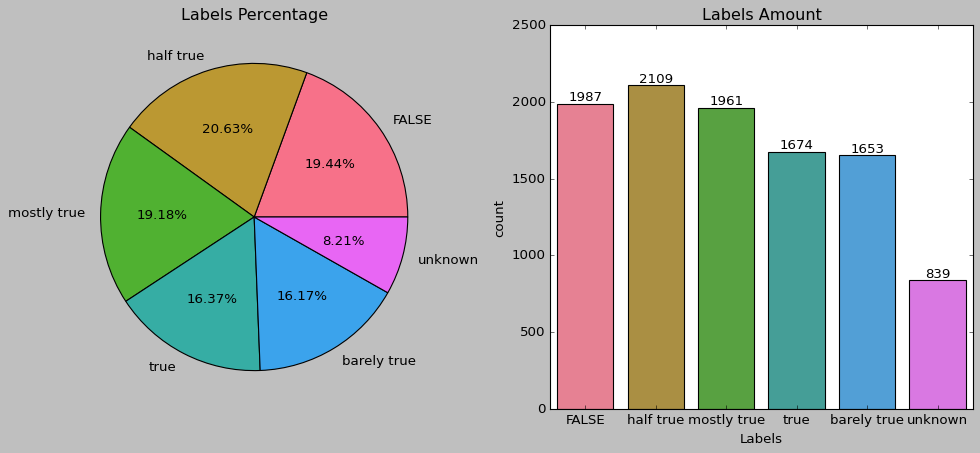

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.pie(df0.Labels.value_counts(sort=False), labels=df0.Labels.unique() ,colors=warna, autopct='%.2f%%')
plt.title('Labels Percentage')

plt.subplot(1,2,2)
ax = sns.countplot(x='Labels', data=df0, palette=warna)
ax.bar_label(ax.containers[0])
plt.title('Labels Amount')
plt.show()

A completely FALSE news is around 19.44%, while a barely-true news is at 16.17%. Those both categories are the labels for the untrusted news, combined into 35.61%.

True is around 16.37% and mostly-true is at 19.18%. Both categories are the reliable information for the readers, and is only at 35.55%. Similar to the untrusted news.

Half-true is the highest percentage with 20.63%, and unknown is the least with 8.21%.


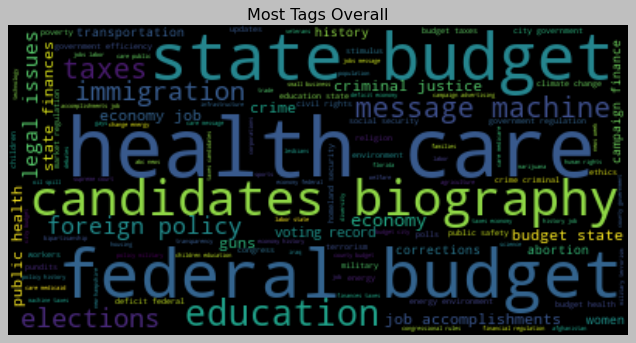

In [28]:
df0_cloud = wordcloud.WordCloud().generate("-".join(df0.Text_Tag.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_cloud)
plt.title('Most Tags Overall')
plt.axis('off')
plt.show()

Overall, folks tends to speaks about Health-care, economy(budget & taxes), politics(candidate & election), education, and immigration.

In [29]:
df0_false = df0.query('Labels=="FALSE" or Labels=="barely true"')
df0_false

Labels                                               Text  \
0            FALSE  Says the Annies List political group supports ...   
3            FALSE  Health care reform legislation is likely to ma...   
6      barely true  Jim Dunnam has not lived in the district he re...   
12           FALSE  When Mitt Romney was governor of Massachusetts...   
14     barely true  Most of the (Affordable Care Act) has already ...   
...            ...                                                ...   
10221        FALSE  As a result of Obamacare, California seniors f...   
10224  barely true  In 2012, the state put together a list of over...   
10228  barely true  Stopped by Smiley Cookie to pick up some great...   
10230  barely true  The Supreme Courts views are radically out of ...   
10238        FALSE  On lifting the U.S. Cuban embargo and allowing...   

                                                Text_Tag  
0                                               abortion  
3                                            health-care  
6                                   candidates-biography  
12                                  history,state-budget  
14                                           health-care  
...                                                  ...  
10221  federal-budget,health-care,medicare,message-ma...  
10224                                          elections  
10228                                               food  
10230              gays-and-lesbians,polls,supreme-court  
10238                             florida,foreign-policy  

[3640 rows x 3 columns]

In [30]:
df0_false.Text_Tag.value_counts()

health-care                                                         161
taxes                                                               103
immigration                                                          95
elections                                                            84
candidates-biography                                                 72
                                                                   ... 
economy,history,job-accomplishments,jobs,labor,states,workers         1
city-government,government-regulation,message-machine-2012,water      1
transparency,women                                                    1
abortion,voting-record                                                1
florida,foreign-policy                                                1
Name: Text_Tag, Length: 1708, dtype: int64

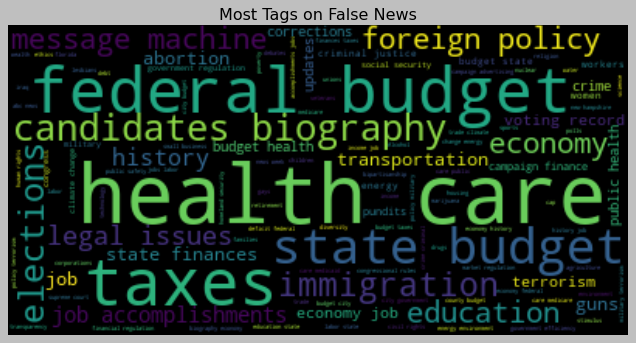

In [31]:
df0_f_cloud = wordcloud.WordCloud().generate("-".join(df0_false.Text_Tag.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_f_cloud)
plt.title('Most Tags on False News')
plt.axis('off')
plt.show()

The top-5 tags for the untrusted news are also about Health-care, economy(budget & taxes), politics(candidate & election), education, and immigration.

In [32]:
df0_true = df0.query('Labels=="true" or Labels=="mostly true"')
df0_true

Labels                                               Text  \
2      mostly true  Hillary Clinton agrees with John McCain "by vo...   
5             true  The Chicago Bears have had more starting quart...   
9      mostly true  Says GOP primary opponents Glenn Grothman and ...   
10     mostly true  For the first time in history, the share of th...   
13     mostly true  The economy bled $24 billion due to the govern...   
...            ...                                                ...   
10223  mostly true  Says Rick Perry turned down our invitation to ...   
10226  mostly true  The proudest accomplishment (of my tenure) was...   
10229  mostly true   Mike Trainor...still owes $250,000 to the state.   
10235  mostly true  There are a larger number of shark attacks in ...   
10236  mostly true  Democrats have now become the party of the [At...   

                                        Text_Tag  
2                                 foreign-policy  
5                                      education  
9      energy,message-machine-2014,voting-record  
10                                     elections  
13            economy,federal-budget,health-care  
...                                          ...  
10223                 bipartisanship,immigration  
10226          state-budget,state-finances,taxes  
10229            bankruptcy,economy,legal-issues  
10235                          animals,elections  
10236                                  elections  

[3635 rows x 3 columns]

In [33]:
df0_true.Text_Tag.value_counts()

taxes                                                               116
education                                                           108
health-care                                                         107
elections                                                           102
immigration                                                          75
                                                                   ... 
education,gambling,state-finances                                     1
crime,criminal-justice,drugs,government-regulation,public-health      1
congress,economy                                                      1
candidates-biography,military                                         1
animals,elections                                                     1
Name: Text_Tag, Length: 1656, dtype: int64

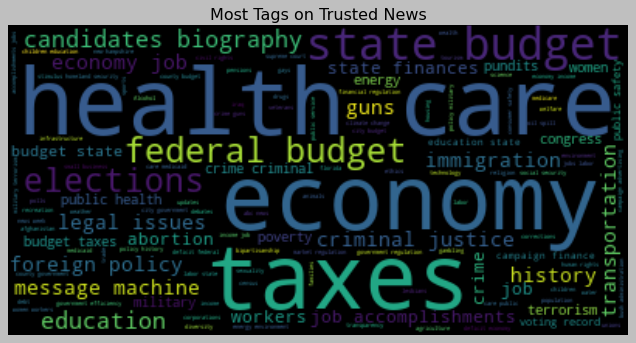

In [34]:
df0_t_cloud = wordcloud.WordCloud().generate("-".join(df0_true.Text_Tag.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_t_cloud)
plt.title('Most Tags on Trusted News')
plt.axis('off')
plt.show()

The top-5 tags for the trusted news are also about Health-care, economy(budget & taxes), politics(candidate & election), education, and immigration.

The funny thing is, the most dominant theme both on the Fake News and True News are actually similar.

Overall, the cardinality in Text_Tag is too high. We need some kind of feature engineering to make it simple.

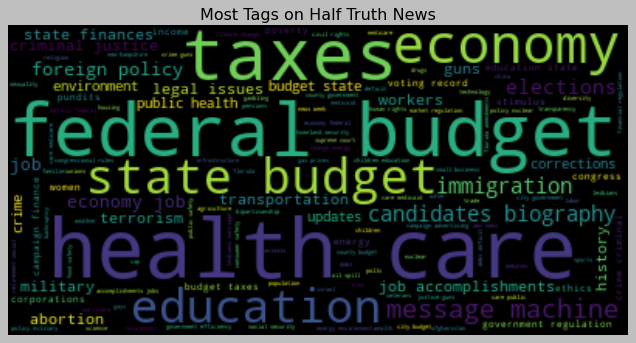

In [35]:
df0_half = df0.query('Labels=="half true"')
df0_h_cloud = wordcloud.WordCloud().generate("-".join(df0_half.Text_Tag.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_h_cloud)
plt.title('Most Tags on Half Truth News')
plt.axis('off')
plt.show()

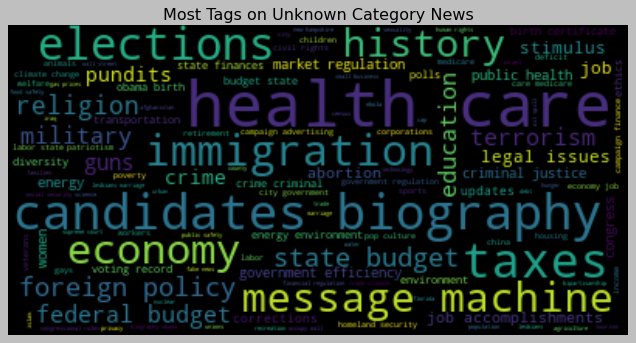

In [36]:
df0_unknown = df0.query('Labels=="unknown"')
df0_u_cloud = wordcloud.WordCloud().generate("-".join(df0_unknown.Text_Tag.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_u_cloud)
plt.title('Most Tags on Unknown Category News')
plt.axis('off')
plt.show()

---

> EDA Part 3

Get a deeper look into Text_Tag

In [37]:
vect_tag = CountVectorizer()

In [38]:
vect_tag.fit(df0['Text_Tag'])
vect_tag.get_feature_names_out()

array(['10', '2012', '2014', 'abc', 'abortion', 'accomplishments',
       'administration', 'advertising', 'afghanistan', 'after',
       'agriculture', 'alcohol', 'amendments', 'and', 'animals', 'autism',
       'bankruptcy', 'baseball', 'bay', 'biography', 'bipartisanship',
       'birth', 'budget', 'bush', 'business', 'campaign', 'candidates',
       'cap', 'care', 'census', 'certificate', 'change', 'children',
       'china', 'city', 'civil', 'climate', 'colbert', 'congress',
       'congressional', 'consumer', 'corporations', 'corrections',
       'county', 'court', 'crime', 'criminal', 'culture', 'death',
       'debates', 'debt', 'deficit', 'disability', 'disasters',
       'diversity', 'drugs', 'ebola', 'economy', 'education',
       'efficiency', 'elections', 'energy', 'environment', 'ethics',
       'fact', 'fake', 'families', 'federal', 'finance', 'finances',
       'financial', 'fires', 'florida', 'food', 'foreign', 'gambling',
       'gas', 'gays', 'government', 'guns', 'h

In [39]:
# membuat spars matrix
tag_matrix = vect_tag.transform(df0['Text_Tag'])
tag_matrix.toarray()
tag_df = pd.DataFrame(tag_matrix.toarray(), columns=vect_tag.get_feature_names_out())
tag_df

10  2012  2014  abc  abortion  accomplishments  administration  \
0       0     0     0    0         1                0               0   
1       0     0     0    0         0                1               0   
2       0     0     0    0         0                0               0   
3       0     0     0    0         0                0               0   
4       0     0     0    0         0                0               0   
...    ..   ...   ...  ...       ...              ...             ...   
10218   0     0     0    0         0                0               0   
10219   0     0     0    0         0                0               0   
10220   0     0     0    0         0                0               0   
10221   0     0     0    0         0                0               0   
10222   0     0     0    0         0                0               0   

       advertising  afghanistan  after  agriculture  alcohol  amendments  and  \
0                0            0      0            0        0           0    0   
1                0            0      0            0        0           0    0   
2                0            0      0            0        0           0    0   
3                0            0      0            0        0           0    0   
4                0            0      0            0        0           0    0   
...            ...          ...    ...          ...      ...         ...  ...   
10218            0            0      0            0        0           0    0   
10219            0            0      0            0        0           0    0   
10220            0            0      0            0        0           0    0   
10221            0            0      0            0        0           0    0   
10222            0            0      0            0        0           0    0   

       animals  autism  bankruptcy  baseball  bay  biography  bipartisanship  \
0            0       0           0         0    0          0               0   
1            0       0           0         0    0          0               0   
2            0       0           0         0    0          0               0   
3            0       0           0         0    0          0               0   
4            0       0           0         0    0          0               0   
...        ...     ...         ...       ...  ...        ...             ...   
10218        1       0           0         0    0          0               0   
10219        0       0           0         0    0          0               0   
10220        0       0           0         0    0          0               0   
10221        0       0           0         0    0          0               0   
10222        0       0           0         0    0          0               0   

       birth  budget  bush  business  campaign  candidates  cap  care  census  \
0          0       0     0         0         0           0    0     0       0   
1          0       0     0         0         0           0    0     0       0   
2          0       0     0         0         0           0    0     0       0   
3          0       0     0         0         0           0    0     1       0   
4          0       0     0         0         0           0    0     0       0   
...      ...     ...   ...       ...       ...         ...  ...   ...     ...   
10218      0       0     0         0         0           0    0     0       0   
10219      0       0     0         0         0           0    0     0       0   
10220      0       0     0         0         0           0    0     0       0   
10221      0       0     0         0         0           0    0     0       0   
10222      0       0     0         0         0           0    0     1       0   

       certificate  change  children  china  city  civil  climate  colbert  \
0                0       0         0      0     0      0        0        0   
1                0       0         0      0     0      0        0  

Now we know that there are around 178 different tags. Some of them maybe not the actual tags, but from this data we can understand how differ the tweet, and the topic is quite wide.

In [40]:
tag = pd.DataFrame(index=tag_df.columns, columns=['total'])

for col in tag_df.columns:
    tag['total'].loc[col] = tag_df[col].sum()

tag


total
10           5
2012       323
2014        40
abc         89
abortion   253
...        ...
weather     36
week        89
welfare     55
women      215
workers    293

[178 rows x 1 columns]

In [41]:
tag_top10 = pd.DataFrame(tag['total'].sort_values(ascending=False).head(10)).T
tag_top10

budget health economy  care taxes state federal education jobs biography
total   1574   1354    1161  1129   994   939     744       728  709       652

Here are the top 10 Tags used in dataset. Those are budget, health, economy, care, taxes, state, federal, education, jobs, and biography.

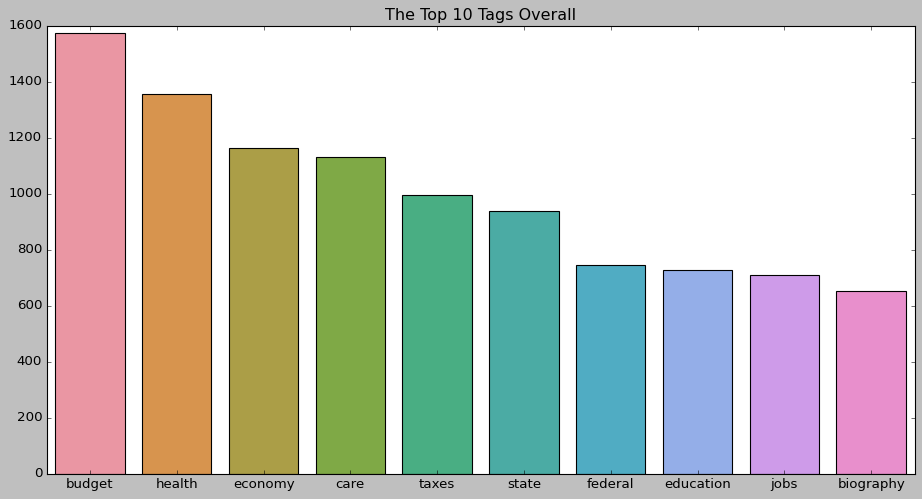

Index(['budget', 'health', 'economy', 'care', 'taxes', 'state', 'federal',
       'education', 'jobs', 'biography'],
      dtype='object')

In [42]:
plt.figure(figsize=(14,7))
sns.barplot(data=tag_top10)
plt.title('The Top 10 Tags Overall')
plt.show()
tag_top10.columns

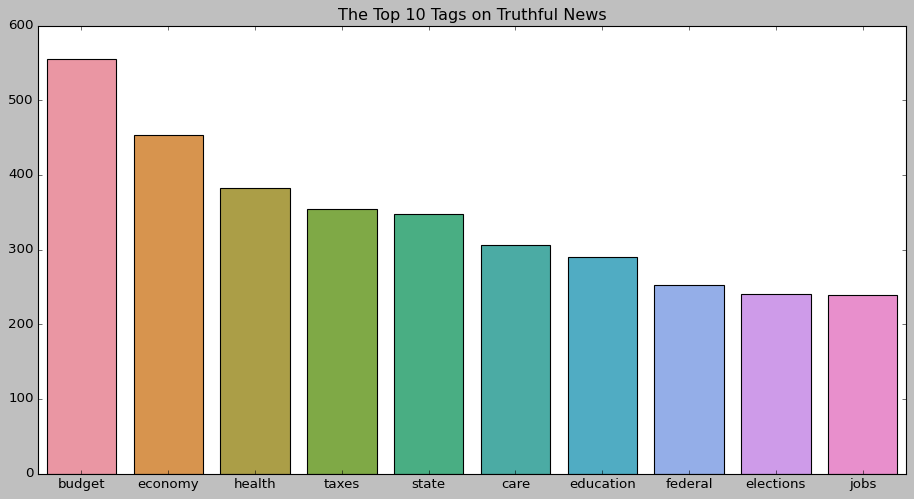

Index(['budget', 'economy', 'health', 'taxes', 'state', 'care', 'education',
       'federal', 'elections', 'jobs'],
      dtype='object')

In [43]:
# Tags on Truthful News

tag_t_matrix = vect_tag.transform(df0_true['Text_Tag'])
tag_t_matrix.toarray()
tag_t_df = pd.DataFrame(tag_t_matrix.toarray(), columns=vect_tag.get_feature_names_out())

tag_t = pd.DataFrame(index=tag_t_df.columns, columns=['total'])

for col in tag_t_df.columns:
    tag_t['total'].loc[col] = tag_t_df[col].sum()

tag_t_top10 = pd.DataFrame(tag_t['total'].sort_values(ascending=False).head(10)).T

plt.figure(figsize=(14,7))
sns.barplot(data=tag_t_top10)
plt.title('The Top 10 Tags on Truthful News')
plt.show()
tag_t_top10.columns

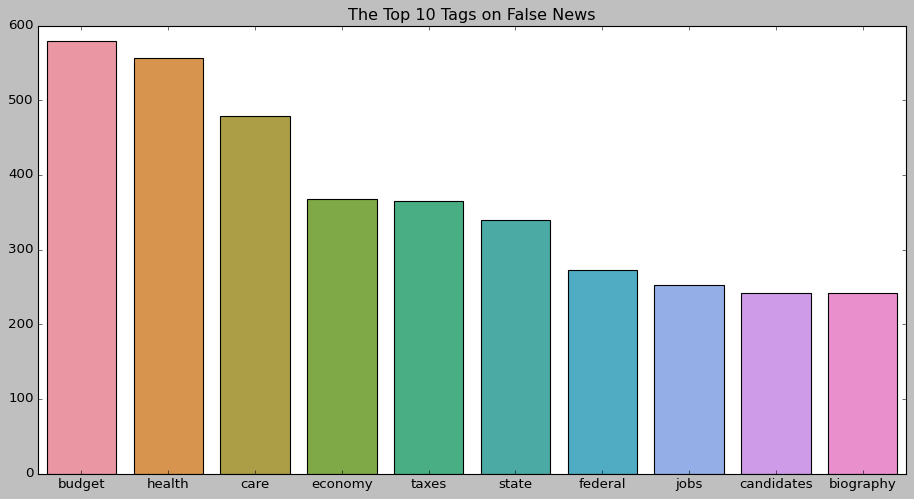

Index(['budget', 'health', 'care', 'economy', 'taxes', 'state', 'federal',
       'jobs', 'candidates', 'biography'],
      dtype='object')

In [44]:
# Tags on False News

tag_f_matrix = vect_tag.transform(df0_false['Text_Tag'])
tag_f_matrix.toarray()
tag_f_df = pd.DataFrame(tag_f_matrix.toarray(), columns=vect_tag.get_feature_names_out())

tag_f = pd.DataFrame(index=tag_f_df.columns, columns=['total'])

for col in tag_f_df.columns:
    tag_f['total'].loc[col] = tag_f_df[col].sum()

tag_f_top10 = pd.DataFrame(tag_f['total'].sort_values(ascending=False).head(10)).T

plt.figure(figsize=(14,7))
sns.barplot(data=tag_f_top10)
plt.title('The Top 10 Tags on False News')
plt.show()
tag_f_top10.columns

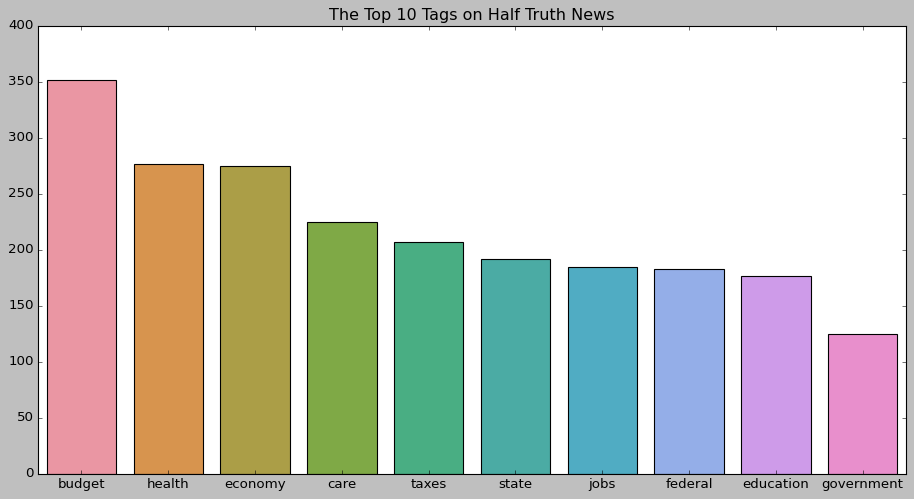

Index(['budget', 'health', 'economy', 'care', 'taxes', 'state', 'jobs',
       'federal', 'education', 'government'],
      dtype='object')

In [45]:
# Tags on Half Truth News

tag_h_matrix = vect_tag.transform(df0_half['Text_Tag'])
tag_h_matrix.toarray()
tag_h_df = pd.DataFrame(tag_h_matrix.toarray(), columns=vect_tag.get_feature_names_out())

tag_h = pd.DataFrame(index=tag_h_df.columns, columns=['total'])

for col in tag_h_df.columns:
    tag_h['total'].loc[col] = tag_h_df[col].sum()

tag_h_top10 = pd.DataFrame(tag_h['total'].sort_values(ascending=False).head(10)).T

plt.figure(figsize=(14,7))
sns.barplot(data=tag_h_top10)
plt.title('The Top 10 Tags on Half Truth News')
plt.show()
tag_h_top10.columns

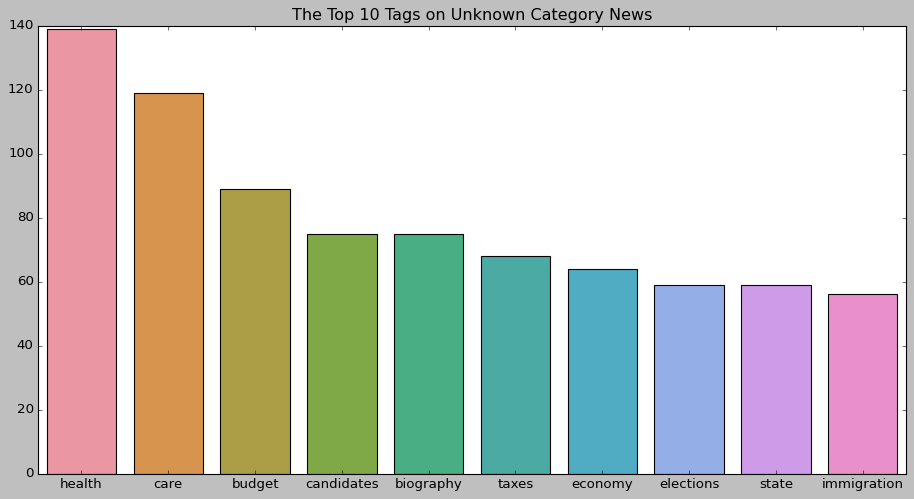

Index(['health', 'care', 'budget', 'candidates', 'biography', 'taxes',
       'economy', 'elections', 'state', 'immigration'],
      dtype='object')

In [46]:
# Tags on Unknown Category News

tag_u_matrix = vect_tag.transform(df0_unknown['Text_Tag'])
tag_u_matrix.toarray()
tag_u_df = pd.DataFrame(tag_u_matrix.toarray(), columns=vect_tag.get_feature_names_out())

tag_u = pd.DataFrame(index=tag_u_df.columns, columns=['total'])

for col in tag_u_df.columns:
    tag_u['total'].loc[col] = tag_u_df[col].sum()

tag_u_top10 = pd.DataFrame(tag_u['total'].sort_values(ascending=False).head(10)).T

plt.figure(figsize=(14,7))
sns.barplot(data=tag_u_top10)
plt.title('The Top 10 Tags on Unknown Category News')
plt.show()
tag_u_top10.columns

> EDA Part 4

Get a Deeper Look into Text

In [47]:
vect_text = TfidfVectorizer()

punct = RegexpTokenizer(r'\w+')

stops = stopwords.words('english')

lemma = WordNetLemmatizer()

df0[['Text_tokenized']] = 'x'

In [48]:
df0

Labels                                               Text  \
0            FALSE  Says the Annies List political group supports ...   
1        half true  When did the decline of coal start? It started...   
2      mostly true  Hillary Clinton agrees with John McCain "by vo...   
3            FALSE  Health care reform legislation is likely to ma...   
4        half true  The economic turnaround started at the end of ...   
...            ...                                                ...   
10235  mostly true  There are a larger number of shark attacks in ...   
10236  mostly true  Democrats have now become the party of the [At...   
10237    half true  Says an alternative to Social Security that op...   
10238        FALSE  On lifting the U.S. Cuban embargo and allowing...   
10239      unknown  The Department of Veterans Affairs has a manua...   

                                 Text_Tag Text_tokenized  
0                                abortion              x  
1      energy,history,job-accomplishments              x  
2                          foreign-policy              x  
3                             health-care              x  
4                            economy,jobs              x  
...                                   ...            ...  
10235                   animals,elections              x  
10236                           elections              x  
10237          retirement,social-security              x  
10238              florida,foreign-policy              x  
10239                health-care,veterans              x  

[10223 rows x 4 columns]

In [49]:
for i in df0.Text.index:
    df0.Text_tokenized.loc[i] = df0.Text.loc[i].lower() # lowering the sentences
    df0.Text_tokenized.loc[i] = re.sub(r'\d+', '', df0.Text_tokenized.loc[i]) # removing the numbers

vect_text.fit(df0['Text_tokenized'])

# remove stopwords, punctuation, and did some lemmatization
for i in df0.Text.index:    
    txt = punct.tokenize(df0.Text_tokenized.loc[i])
    txt = [word for word in txt if not word in stops]
    txt = [lemma.lemmatize(i) for i in txt]
    df0.Text_tokenized.loc[i] = ' '.join(txt)
    txt_token = df0.Text_tokenized.loc[i]

In [50]:
df0

Labels                                               Text  \
0            FALSE  Says the Annies List political group supports ...   
1        half true  When did the decline of coal start? It started...   
2      mostly true  Hillary Clinton agrees with John McCain "by vo...   
3            FALSE  Health care reform legislation is likely to ma...   
4        half true  The economic turnaround started at the end of ...   
...            ...                                                ...   
10235  mostly true  There are a larger number of shark attacks in ...   
10236  mostly true  Democrats have now become the party of the [At...   
10237    half true  Says an alternative to Social Security that op...   
10238        FALSE  On lifting the U.S. Cuban embargo and allowing...   
10239      unknown  The Department of Veterans Affairs has a manua...   

                                 Text_Tag  \
0                                abortion   
1      energy,history,job-accomplishments   
2                          foreign-policy   
3                             health-care   
4                            economy,jobs   
...                                   ...   
10235                   animals,elections   
10236                           elections   
10237          retirement,social-security   
10238              florida,foreign-policy   
10239                health-care,veterans   

                                          Text_tokenized  
0      say annies list political group support third ...  
1      decline coal start started natural gas took st...  
2      hillary clinton agrees john mccain voting give...  
3      health care reform legislation likely mandate ...  
4                   economic turnaround started end term  
...                                                  ...  
10235  larger number shark attack florida case voter ...  
10236     democrat become party atlanta metro area black  
10237  say alternative social security operates galve...  
10238       lifting u cuban embargo allowing travel cuba  
10239  department veteran affair manual telling veter...  

[10223 rows x 4 columns]

In [51]:
# creating spars matrix
text_matrix = vect_text.transform(df0['Text_tokenized'])
text_matrix.toarray()
text_df = pd.DataFrame(text_matrix.toarray(), columns=vect_text.get_feature_names_out())
text_df

aa  aaa  aaron  aarp  aba  abandoned  abandoning  abbas  abbott  abc  \
0      0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
1      0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
2      0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
3      0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
4      0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
...    ...  ...    ...   ...  ...        ...         ...    ...     ...  ...   
10218  0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
10219  0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
10220  0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
10221  0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   
10222  0.0  0.0    0.0   0.0  0.0        0.0         0.0    0.0     0.0  0.0   

       abdul  abedin  abele  abide  abiding  abilities  ability  abill  \
0        0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
1        0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
2        0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
3        0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
4        0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
...      ...     ...    ...    ...      ...        ...      ...    ...   
10218    0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
10219    0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
10220    0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
10221    0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   
10222    0.0     0.0    0.0    0.0      0.0        0.0      0.0    0.0   

       abillion  abject  able  aboard  abolish  abolished  abolishes  \
0           0.0     0.0   0.0     0.0      0.0        0.0        0.0   
1           0.0     0.0   0.0     0.0      0.0        0.0        0.0   
2           0.0     0.0   0.0     0.0      0.0        0.0        0.0   
3           0.0     0.0   0.0     0.0      0.0        0.0        0.0   
4           0.0     0.0   0.0     0.0      0.0        0.0        0.0   
...         ...     ...   ...     ...      ...        ...        ...   
10218       0.0     0.0   0.0     0.0      0.0        0.0        0.0   
10219       0.0     0.0   0.0     0.0      0.0        0.0        0.0   
10220       0.0     0.0   0.0     0.0      0.0        0.0        0.0   
10221       0.0     0.0   0.0     0.0      0.0        0.0        0.0   
10222       0.0     0.0   0.0     0.0      0.0        0.0        0.0   

       abolishing  abolition  abort  aborted  abortion  abortioneven  \
0             0.0        0.0    0.0      0.0  0.253156           0.0   
1             0.0        0.0    0.0      0.0  0.000000           0.0   
2             0.0        0.0    0.0      0.0  0.000000           0.0   
3             0.0        0.0    0.0      0.0  0.000000           0.0   
4             0.0        0.0    0.0      0.0  0.000000           0.0   
...           ...        ...    ...      ...       ...           ...   
10218         0.0        0.0    0.0      0.0  0.000000           0.0   
10219         0.0        0.0    0.0      0.0  0.000000           0.0   
10220         0.0        0.0    0.0      0.0  0.000000           0.0   
10221         0.0        0.0    0.0      0.0  0.000000           0.0   
10222         0.0        0.0    0.0      0.0  0.000000           0.0   

       abortionists  abortions  about  above  abraham  abrahamlincoln  \
0               0.0        0.0    0.0    0.0      0.0             0.0   
1               0.0        0.0    0.0    0.0      0.0             0.0   
2               0.0        0.0    0.0    0.0      0.0             0.0   
3               0.0        0.0    0.0    0.0      0.0             0.0   
4               0.0        0.0    0.0    0.0      0.0          

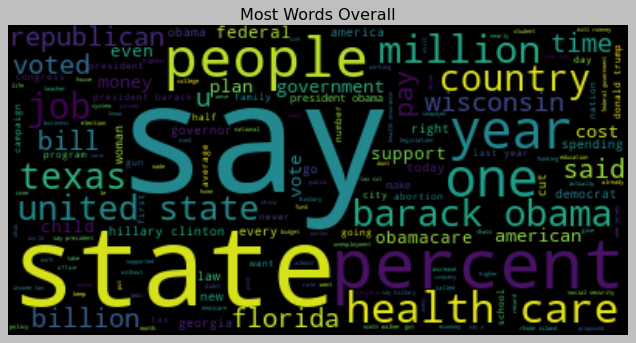

In [52]:
df0_cloud = wordcloud.WordCloud().generate("-".join(df0.Text_tokenized.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_cloud)
plt.title('Most Words Overall')
plt.axis('off')
plt.show()

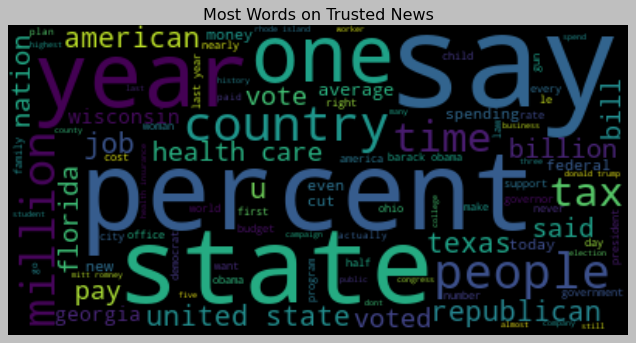

In [53]:
df0_true = df0.query('Labels=="true" or Labels=="mostly true"')
df0_t_cloud = wordcloud.WordCloud().generate("-".join(df0_true.Text_tokenized.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_t_cloud)
plt.title('Most Words on Trusted News')
plt.axis('off')
plt.show()

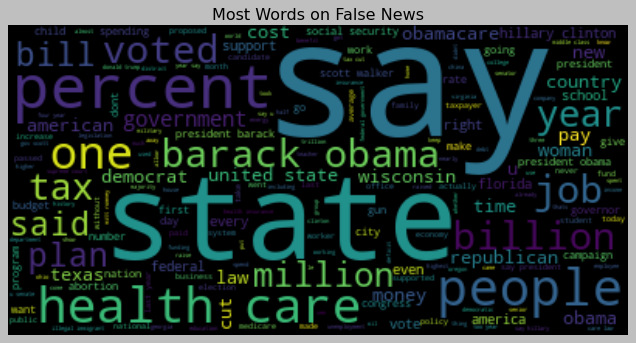

In [54]:
df0_false = df0.query('Labels=="FALSE" or Labels=="barely true"')
df0_f_cloud = wordcloud.WordCloud().generate("-".join(df0_false.Text_tokenized.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_f_cloud)
plt.title('Most Words on False News')
plt.axis('off')
plt.show()

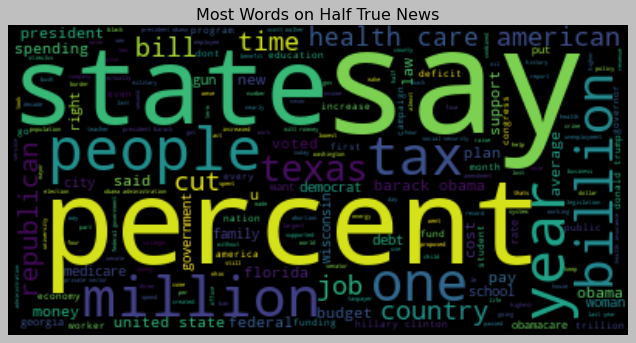

In [55]:
df0_half = df0.query('Labels=="half true"')
df0_h_cloud = wordcloud.WordCloud().generate("-".join(df0_half.Text_tokenized.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_h_cloud)
plt.title('Most Words on Half True News')
plt.axis('off')
plt.show()

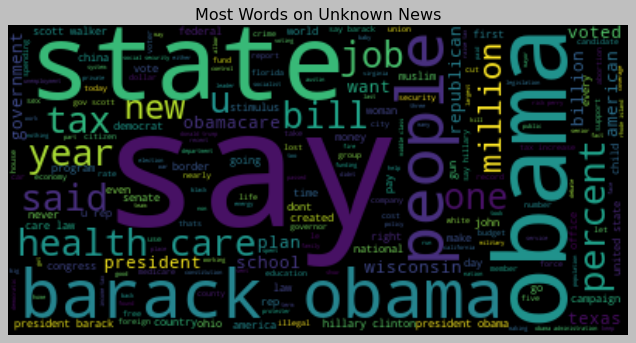

In [56]:
df0_unknown = df0.query('Labels=="unknown"')
df0_u_cloud = wordcloud.WordCloud().generate("-".join(df0_unknown.Text_tokenized.astype(str)))
plt.figure(figsize=(10,6))
plt.imshow(df0_u_cloud)
plt.title('Most Words on Unknown News')
plt.axis('off')
plt.show()

The most occuring words looks like the same or very similar between different categories. So we could just move on into preprocessing Data

---

# 5-Data Preprocessing

In [57]:
df = df00.copy()
df = df.drop_duplicates(['Text'])
df.reset_index(drop=True, inplace=True)

> Simplify the Labels

In [58]:
df.Labels.replace(0, 'barely true', inplace=True)
df.Labels.replace(1, 'FALSE', inplace=True)
df.Labels.replace(2, 'half true', inplace=True)
df.Labels.replace(3, 'mostly true', inplace=True)
df.Labels.replace(4, 'unknown', inplace=True)
df.Labels.replace(5, 'true', inplace=True)
df.Labels = df.Labels.astype('object')

In [59]:
df.Labels.replace('barely true', 0, inplace=True)
df.Labels.replace('FALSE', 0, inplace=True)
df.Labels.replace('half true', 1, inplace=True)
df.Labels.replace('unknown', 1, inplace=True)
df.Labels.replace('mostly true', 2, inplace=True)
df.Labels.replace('true', 2, inplace=True)
df.Labels = df.Labels.astype('int')

Now, the labels says this:
- 0 : False or barely true
- 1 : unknown or 50:50
- 2 : mostly true, or true 100%

In [60]:
df

Labels                                               Text  \
0           0  Says the Annies List political group supports ...   
1           1  When did the decline of coal start? It started...   
2           2  Hillary Clinton agrees with John McCain "by vo...   
3           0  Health care reform legislation is likely to ma...   
4           1  The economic turnaround started at the end of ...   
...       ...                                                ...   
10218       2  There are a larger number of shark attacks in ...   
10219       2  Democrats have now become the party of the [At...   
10220       1  Says an alternative to Social Security that op...   
10221       0  On lifting the U.S. Cuban embargo and allowing...   
10222       1  The Department of Veterans Affairs has a manua...   

                                 Text_Tag  
0                                abortion  
1      energy,history,job-accomplishments  
2                          foreign-policy  
3                             health-care  
4                            economy,jobs  
...                                   ...  
10218                   animals,elections  
10219                           elections  
10220          retirement,social-security  
10221              florida,foreign-policy  
10222                health-care,veterans  

[10223 rows x 3 columns]

> Missing Value Handling

In [61]:
df.isna().sum()

Labels      0
Text        0
Text_Tag    2
dtype: int64

In [62]:
df.Text_Tag.fillna('xxx', inplace=True)
df.query('Text_Tag=="xxx"')

Labels                                               Text Text_Tag
2139       0  The fact is that although we have had a presid...      xxx
9361       0  Joe, I keep hearing you every morning talking ...      xxx

In [63]:
df.Text.iloc[2139]

'The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.\'\'\tabortion\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json\ttrue\tMost of the jobs that we lost were lost before the economic policies we put in place had any effect.\teconomy,job-accomplishments,jobs,stimulus\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview on The Daily Show with Jon Stewart"'

In [64]:
df.Text.loc[9361]

"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.''\thealth-care,taxes\trichard-durbin\tSenator\tIllinois\tdemocrat\t0\t2\t1\t0\t1\ta comment on the Morning Joe'' show on MSNBC."

We have to manually correcting the sentences on both data above.

In [65]:
df.Text.loc[2139] = '"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down", TV interview with megachurch pastor Rick Warren in Lake Forest, Calif. "Most of the jobs that we lost were lost before the economic policies we put in place had any effect", an interview on The Daily Show with Jon Stewart.'
df.Text.loc[9361] = '"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you dont mention it is also the biggest tax cut in history", comment on the Morning Joe show on MSNBC.'

C:\Users\blapupup laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now we also have to manually give them the proper tags according to the sentences.

In [66]:
df.Text_Tag.loc[2139] = 'abortion,economy,jobs,stimulus'
df.Text_Tag.loc[9361] = 'health-care,taxes'

In [67]:
df.isna().sum()

Labels      0
Text        0
Text_Tag    0
dtype: int64

We consider the Text_Tag also contains important information to determine whether the news is false or not, so the tags will become the first part of the sentences.

In [68]:
df['Feature'] = df['Text_Tag'] + ' ' + df['Text']

In [69]:
df

Labels                                               Text  \
0           0  Says the Annies List political group supports ...   
1           1  When did the decline of coal start? It started...   
2           2  Hillary Clinton agrees with John McCain "by vo...   
3           0  Health care reform legislation is likely to ma...   
4           1  The economic turnaround started at the end of ...   
...       ...                                                ...   
10218       2  There are a larger number of shark attacks in ...   
10219       2  Democrats have now become the party of the [At...   
10220       1  Says an alternative to Social Security that op...   
10221       0  On lifting the U.S. Cuban embargo and allowing...   
10222       1  The Department of Veterans Affairs has a manua...   

                                 Text_Tag  \
0                                abortion   
1      energy,history,job-accomplishments   
2                          foreign-policy   
3                             health-care   
4                            economy,jobs   
...                                   ...   
10218                   animals,elections   
10219                           elections   
10220          retirement,social-security   
10221              florida,foreign-policy   
10222                health-care,veterans   

                                                 Feature  
0      abortion Says the Annies List political group ...  
1      energy,history,job-accomplishments When did th...  
2      foreign-policy Hillary Clinton agrees with Joh...  
3      health-care Health care reform legislation is ...  
4      economy,jobs The economic turnaround started a...  
...                                                  ...  
10218  animals,elections There are a larger number of...  
10219  elections Democrats have now become the party ...  
10220  retirement,social-security Says an alternative...  
10221  florida,foreign-policy On lifting the U.S. Cub...  
10222  health-care,veterans The Department of Veteran...  

[10223 rows x 4 columns]

> Splitting into Train, Test, and Val

In [70]:
x = df['Feature']
y = df['Labels']

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=20, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=20, stratify=y_train_val)

x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

> Preparing the Target

In [71]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

> Vectorization

In [243]:
max_vocab_length = 9000 #vocabulary
max_length = 32 #sentences

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        ngrams=None,
                                        output_mode='int',
                                        output_sequence_length=max_length)

In [244]:
# preparing the vocabulary
text_vectorization.adapt(x_train)

In [245]:
# testing new tweet
sample_tweet = "Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors"
text_vectorization(sample_tweet)

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([4417, 5832,  349,    6,   96,   10,   56,  101, 1651,    9,  111,
       1854,  472,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)>

In [246]:
text_vectorization.get_vocabulary()[443] # checking the vocab

'troops'

> Embedding

In [247]:
embed = Embedding(input_dim=max_vocab_length,
                    output_dim=32,
                    embeddings_initializer='uniform',
                    input_length=max_length)

embed.trainable = True

In [248]:
# testing new tweet
sample_tweet = 'Says the unemployment rate for college graduates is 4.4 percent and over 10 percent for noncollege-educated.'

sample_tweet_vec = text_vectorization([sample_tweet])
sample_tweet_embed = embed(sample_tweet_vec)
sample_tweet_embed

<tf.Tensor: shape=(1, 32, 32), dtype=float32, numpy=
array([[[-0.00516639, -0.02105688, -0.03392657, ...,  0.019245  ,
          0.00321199,  0.00822207],
        [ 0.02105359, -0.01199328,  0.01967612, ..., -0.00431713,
         -0.03441311,  0.00762122],
        [-0.00822917,  0.03755869, -0.0481869 , ..., -0.00359875,
          0.01445936,  0.00138315],
        ...,
        [ 0.01683788,  0.019905  ,  0.00989841, ...,  0.02845273,
          0.04490991,  0.00506294],
        [ 0.01683788,  0.019905  ,  0.00989841, ...,  0.02845273,
          0.04490991,  0.00506294],
        [ 0.01683788,  0.019905  ,  0.00989841, ...,  0.02845273,
          0.04490991,  0.00506294]]], dtype=float32)>

---

# 6-Defining the Model

> Neural Network

In [279]:
gap = GlobalAveragePooling1D()

inputs = Input(shape=(1,), dtype='string')
a = text_vectorization(inputs)
b = embed(a)
c = gap(b)
outputs = Dense(3, activation='softmax')(c)
model_NN = Model(inputs, outputs, name='nlp_fcn')

# compile
model_NN.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

> LSTM

In [280]:
lstm = LSTM(16)

inputs = Input(shape=(1,), dtype='string')
a = text_vectorization(inputs)
b = embed(a)
c = lstm(b)
outputs = Dense(3, activation='softmax')(c)
model_LSTM = Model(inputs, outputs, name='nlp_lstm')

# compile
model_LSTM.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

> GRU

In [281]:
gru = GRU(16)

inputs = Input(shape=(1,), dtype='string')
a = text_vectorization(inputs)
b = embed(a)
c = gru(b)
outputs = Dense(3, activation='softmax')(c)
model_GRU = Model(inputs, outputs, name='nlp_gru')

# compile
model_GRU.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

---

# 7-Model Training

> Neural Network

In [282]:
hist_NN = model_NN.fit(x_train, y_train_ohe, epochs=10, validation_data=(x_val,y_val_ohe))

Epoch 1/10
205/205 [==============================] - 1s 5ms/step - loss: 1.0164 - accuracy: 0.6458 - val_loss: 1.0762 - val_accuracy: 0.4285
Epoch 2/10
205/205 [==============================] - 1s 4ms/step - loss: 0.8907 - accuracy: 0.7751 - val_loss: 1.0718 - val_accuracy: 0.4144
Epoch 3/10
205/205 [==============================] - 1s 4ms/step - loss: 0.7827 - accuracy: 0.8308 - val_loss: 1.0805 - val_accuracy: 0.4205
Epoch 4/10
205/205 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.8580 - val_loss: 1.1003 - val_accuracy: 0.4169
Epoch 5/10
205/205 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.8751 - val_loss: 1.1273 - val_accuracy: 0.4224
Epoch 6/10
205/205 [==============================] - 1s 4ms/step - loss: 0.5533 - accuracy: 0.8866 - val_loss: 1.1615 - val_accuracy: 0.4187
Epoch 7/10
205/205 [==============================] - 1s 4ms/step - loss: 0.5014 - accuracy: 0.8980 - val_loss: 1.1978 - val_accuracy: 0.4242
Epoch 

<AxesSubplot:>

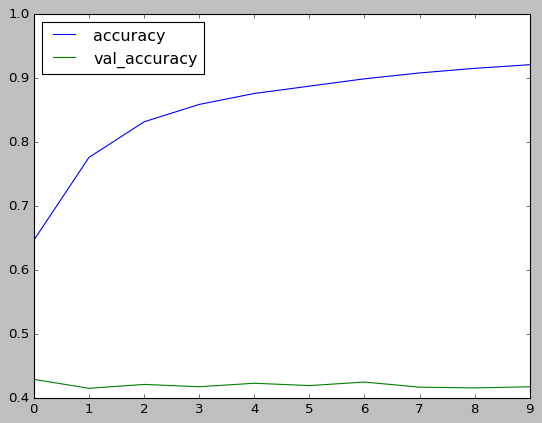

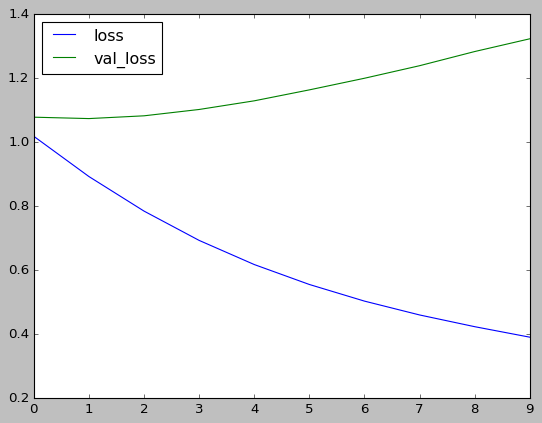

In [283]:
metrics_NN = pd.DataFrame(hist_NN.history)
metrics_NN[['accuracy', 'val_accuracy']].plot()
metrics_NN[['loss', 'val_loss']].plot()

> LSTM

In [284]:
hist_LSTM = model_LSTM.fit(x_train, y_train_ohe, epochs=20, validation_data=(x_val,y_val_ohe))

Epoch 1/20
205/205 [==============================] - 4s 14ms/step - loss: 0.6437 - accuracy: 0.7149 - val_loss: 1.8500 - val_accuracy: 0.3985
Epoch 2/20
205/205 [==============================] - 2s 11ms/step - loss: 0.1956 - accuracy: 0.9474 - val_loss: 2.3394 - val_accuracy: 0.3839
Epoch 3/20
205/205 [==============================] - 2s 11ms/step - loss: 0.0952 - accuracy: 0.9758 - val_loss: 2.6138 - val_accuracy: 0.4022
Epoch 4/20
205/205 [==============================] - 2s 11ms/step - loss: 0.0681 - accuracy: 0.9824 - val_loss: 2.9022 - val_accuracy: 0.4010
Epoch 5/20
205/205 [==============================] - 2s 11ms/step - loss: 0.0519 - accuracy: 0.9891 - val_loss: 3.1341 - val_accuracy: 0.3851
Epoch 6/20
205/205 [==============================] - 2s 11ms/step - loss: 0.0421 - accuracy: 0.9905 - val_loss: 3.1156 - val_accuracy: 0.3826
Epoch 7/20
205/205 [==============================] - 2s 11ms/step - loss: 0.0428 - accuracy: 0.9907 - val_loss: 3.3038 - val_accuracy: 0.3869

<AxesSubplot:>

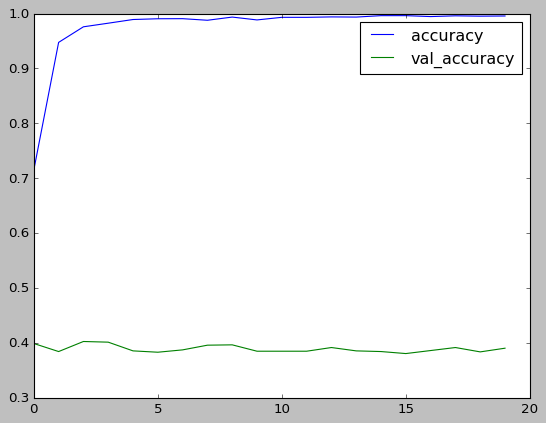

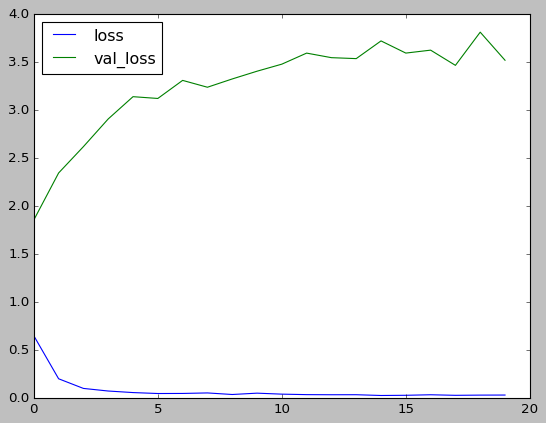

In [285]:
metrics_LSTM = pd.DataFrame(hist_LSTM.history)
metrics_LSTM[['accuracy', 'val_accuracy']].plot()
metrics_LSTM[['loss', 'val_loss']].plot()

> GRU

In [286]:
hist_GRU = model_GRU.fit(x_train, y_train_ohe, epochs=20, validation_data=(x_val,y_val_ohe))

Epoch 1/20
205/205 [==============================] - 5s 15ms/step - loss: 1.0791 - accuracy: 0.3979 - val_loss: 1.0914 - val_accuracy: 0.4065
Epoch 2/20
205/205 [==============================] - 3s 13ms/step - loss: 0.3546 - accuracy: 0.8699 - val_loss: 2.2740 - val_accuracy: 0.3943
Epoch 3/20
205/205 [==============================] - 3s 14ms/step - loss: 0.0711 - accuracy: 0.9797 - val_loss: 2.8332 - val_accuracy: 0.3961
Epoch 4/20
205/205 [==============================] - 3s 13ms/step - loss: 0.0332 - accuracy: 0.9931 - val_loss: 3.1451 - val_accuracy: 0.3918
Epoch 5/20
205/205 [==============================] - 3s 13ms/step - loss: 0.0279 - accuracy: 0.9942 - val_loss: 3.2908 - val_accuracy: 0.3918
Epoch 6/20
205/205 [==============================] - 3s 13ms/step - loss: 0.0275 - accuracy: 0.9945 - val_loss: 3.3160 - val_accuracy: 0.3900
Epoch 7/20
205/205 [==============================] - 3s 13ms/step - loss: 0.0209 - accuracy: 0.9968 - val_loss: 3.4898 - val_accuracy: 0.3912

<AxesSubplot:>

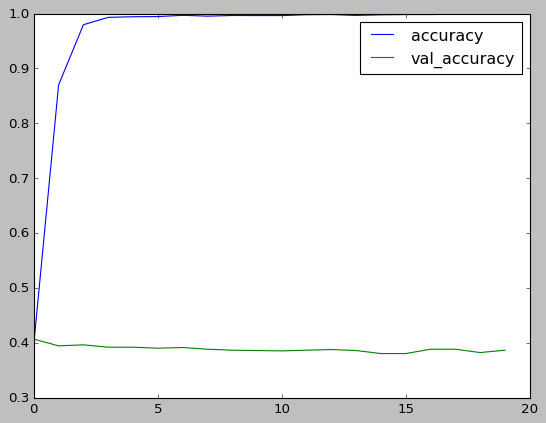

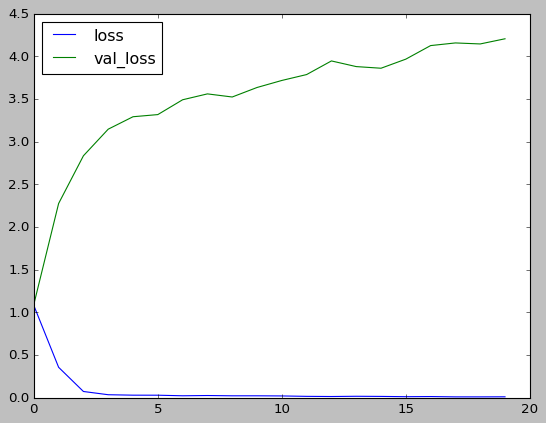

In [287]:
metrics_GRU = pd.DataFrame(hist_GRU.history)
metrics_GRU[['accuracy', 'val_accuracy']].plot()
metrics_GRU[['loss', 'val_loss']].plot()

---

# 8-Model Evaluation

> Neural Network

In [288]:
y_NN = model_NN.predict(x_test)

y_NN = y_NN.argmax(axis=1)

print(classification_report(y_test, y_NN))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42       728
           1       0.32      0.30      0.31       590
           2       0.44      0.45      0.44       727

    accuracy                           0.40      2045
   macro avg       0.39      0.39      0.39      2045
weighted avg       0.40      0.40      0.40      2045



> LSTM

In [289]:
y_LSTM = model_LSTM.predict(x_test)

y_LSTM = y_LSTM.argmax(axis=1)

print(classification_report(y_test, y_LSTM))

              precision    recall  f1-score   support

           0       0.41      0.46      0.43       728
           1       0.31      0.26      0.28       590
           2       0.43      0.43      0.43       727

    accuracy                           0.39      2045
   macro avg       0.38      0.38      0.38      2045
weighted avg       0.39      0.39      0.39      2045



> GRU

In [290]:
y_GRU = model_GRU.predict(x_test)

y_GRU = y_GRU.argmax(axis=1)

print(classification_report(y_test, y_GRU))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41       728
           1       0.31      0.31      0.31       590
           2       0.42      0.40      0.41       727

    accuracy                           0.38      2045
   macro avg       0.38      0.38      0.38      2045
weighted avg       0.38      0.38      0.38      2045



Looks like from those 3 of our models, not even one of them can perform well. Maybe it happens because the dataset is not quite compatible to be analyzed neither with deep learning nor neural network. The other possibility is maybe because the similarity between those text contained in different labels, is too similar.

---

# 9-Model Improvement

> LSTM Improved

In [302]:
lstm_i = LSTM(8)

inputs = Input(shape=(1,), dtype='string')
a = text_vectorization(inputs)
b = embed(a)
b = Dropout(0.2)(b)
c = lstm_i(b)
c = Dropout(0.2)(c)
outputs = Dense(3, activation='softmax')(c)
model_LSTM_i = Model(inputs, outputs, name='nlp_lstm')

# compile
model_LSTM_i.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [303]:
hist_LSTM_i = model_LSTM_i.fit(x_train, y_train_ohe, epochs=3, validation_data=(x_val,y_val_ohe))

Epoch 1/3
205/205 [==============================] - 6s 17ms/step - loss: 0.9843 - accuracy: 0.4804 - val_loss: 1.4733 - val_accuracy: 0.3998
Epoch 2/3
205/205 [==============================] - 3s 14ms/step - loss: 0.4770 - accuracy: 0.8409 - val_loss: 1.8763 - val_accuracy: 0.3906
Epoch 3/3
205/205 [==============================] - 3s 14ms/step - loss: 0.2322 - accuracy: 0.9480 - val_loss: 2.2277 - val_accuracy: 0.3918


<AxesSubplot:>

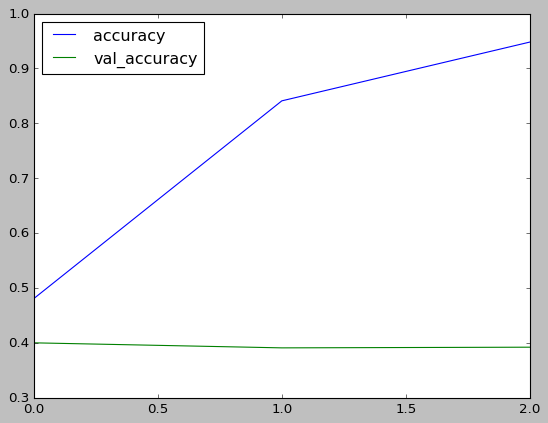

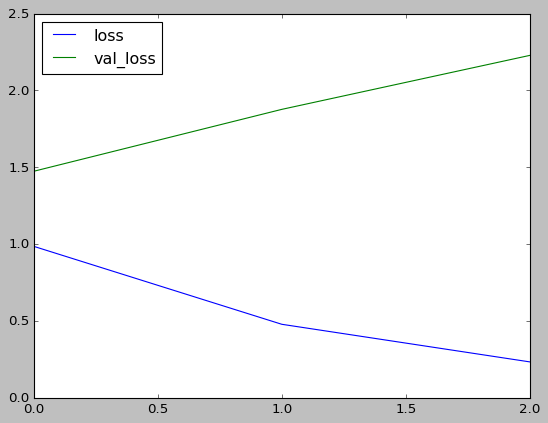

In [304]:
metrics_LSTM_i = pd.DataFrame(hist_LSTM_i.history)
metrics_LSTM_i[['accuracy', 'val_accuracy']].plot()
metrics_LSTM_i[['loss', 'val_loss']].plot()

In [305]:
y_LSTM_i = model_LSTM_i.predict(x_test)
y_LSTM_i = y_LSTM_i.argmax(axis=1)
print(classification_report(y_test, y_LSTM_i))

              precision    recall  f1-score   support

           0       0.42      0.46      0.44       728
           1       0.31      0.29      0.30       590
           2       0.43      0.41      0.42       727

    accuracy                           0.39      2045
   macro avg       0.39      0.39      0.39      2045
weighted avg       0.39      0.39      0.39      2045



> GRU Improved

In [306]:
gru_i = GRU(8)

inputs = Input(shape=(1,), dtype='string')
a = text_vectorization(inputs)
b = embed(a)
b = Dropout(0.2)(b)
c = gru_i(b)
c = Dropout(0.2)(c)
outputs = Dense(3, activation='softmax')(c)
model_GRU_i = Model(inputs, outputs, name='nlp_gru')

# compile
model_GRU_i.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [307]:
hist_GRU_i = model_GRU_i.fit(x_train, y_train_ohe, epochs=3, validation_data=(x_val,y_val_ohe))

Epoch 1/3
205/205 [==============================] - 6s 18ms/step - loss: 1.0917 - accuracy: 0.3696 - val_loss: 1.0920 - val_accuracy: 0.3637
Epoch 2/3
205/205 [==============================] - 3s 15ms/step - loss: 0.7962 - accuracy: 0.5972 - val_loss: 1.6755 - val_accuracy: 0.3600
Epoch 3/3
205/205 [==============================] - 3s 14ms/step - loss: 0.4073 - accuracy: 0.8479 - val_loss: 2.2150 - val_accuracy: 0.3808


<AxesSubplot:>

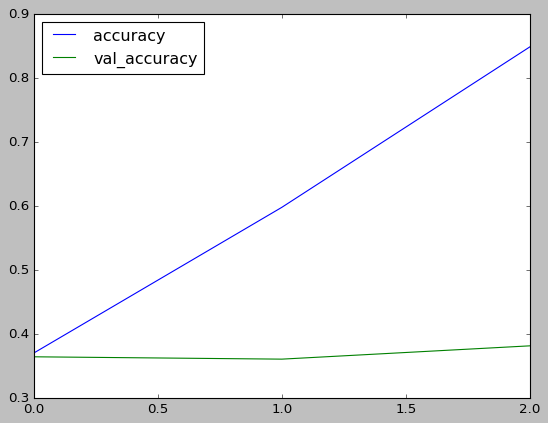

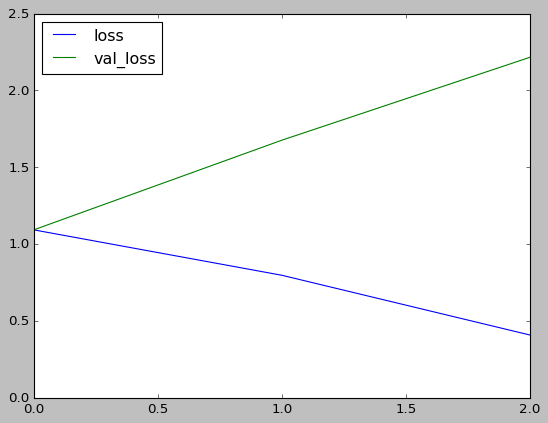

In [308]:
metrics_GRU_i = pd.DataFrame(hist_GRU_i.history)
metrics_GRU_i[['accuracy', 'val_accuracy']].plot()
metrics_GRU_i[['loss', 'val_loss']].plot()

In [309]:
y_GRU_i = model_GRU_i.predict(x_test)

y_GRU_i = y_GRU_i.argmax(axis=1)

print(classification_report(y_test, y_GRU_i))

              precision    recall  f1-score   support

           0       0.37      0.44      0.40       728
           1       0.31      0.27      0.29       590
           2       0.42      0.38      0.40       727

    accuracy                           0.37      2045
   macro avg       0.37      0.36      0.36      2045
weighted avg       0.37      0.37      0.37      2045



---

# 10-Model Saving

Altough those 3 models have similar performance, Improved LSTM is slightly the best around. So we will choose it as our main model.

In [313]:
model_LSTM_i.save('model_BEST.tf')
print('Model saved!')

INFO:tensorflow:Assets written to: model_BEST.tf\assets


INFO:tensorflow:Assets written to: model_BEST.tf\assets


Model saved!


---

# 11-Model Inference

In [314]:
df_inf = pd.read_csv('inference.csv')
df_inf['feature'] = df_inf['Text_Tag'] + ' ' + df_inf['Text']
df_inf = pd.DataFrame(df_inf.feature)
df_inf = df_inf.head(10)

df_inf

feature
0  immigration Building a wall on the U.S.-Mexico...
1  jobs Wisconsin is on pace to double the number...
2  military,veterans,voting-record Says John McCa...
3  medicare,message-machine-2012,campaign-adverti...
4  campaign-finance,legal-issues,campaign-adverti...
5  federal-budget,pensions,retirement Over the pa...
6  county-budget,county-government,education,taxe...
7  economy,stimulus Says Vice President Joe Biden...
8  gays-and-lesbians,marriage Donald Trump is aga...
9  foreign-policy We know that more than half of ...

In [318]:
# load deep learning model
model_BEST = load_model('model_BEST.tf')

df_inf_pred = model_BEST.predict(df_inf)
df_inf_pred = (df_inf_pred.argmax(axis=1))
df_inf_result = df_inf.copy()
df_inf_result['predicted_label'] = ''
df_inf_result['predicted_label'] = df_inf_pred

df_inf_result.predicted_label.replace(0, 'FALSE or barely true', inplace=True)
df_inf_result.predicted_label.replace(1, 'unknown (50:50)', inplace=True)
df_inf_result.predicted_label.replace(2, 'TRUE or mostly true', inplace=True)
df_inf_result.predicted_label = df_inf_result.predicted_label.astype('object')

df_inf_result

feature       predicted_label
0  immigration Building a wall on the U.S.-Mexico...       unknown (50:50)
1  jobs Wisconsin is on pace to double the number...  FALSE or barely true
2  military,veterans,voting-record Says John McCa...       unknown (50:50)
3  medicare,message-machine-2012,campaign-adverti...  FALSE or barely true
4  campaign-finance,legal-issues,campaign-adverti...  FALSE or barely true
5  federal-budget,pensions,retirement Over the pa...  FALSE or barely true
6  county-budget,county-government,education,taxe...       unknown (50:50)
7  economy,stimulus Says Vice President Joe Biden...  FALSE or barely true
8  gays-and-lesbians,marriage Donald Trump is aga...   TRUE or mostly true
9  foreign-policy We know that more than half of ...   TRUE or mostly true

---

# 12-Conclusions

> EDA Analysis

- Some of the data were not built well, causing the sentences' formed badly, therefore the tags became unknown. These kind of missing value is actually common in dataset. Repairing them first is crucial so we can work on a clean dataset later on.

- There are 5 different labels in this dataset: false, barely true, half true, mostly true, true, and unknown. The precentage of each label is not so different, except for the unknown label which is quite low compared to the others.

- Whether on the true news, false news, somewhere in between, and even in the unknown, the tags amongst them revolve around health-care, economy (budget & taxes), politics (candidates & election), education, and immigration. It looks like the people there really taking public matters seriously in their tweet.

- The most occuring words are: say, state, health-care, percent, people, million, billion, tax, jobs, and Barrack Obama. It reflects the tags nicely where most of the topics are about health-care, economy, and politics.

> Model Analysis

- There are 3 models that I used here, those are: Neural Network, LSTM, and GRU. The Deep Learning models are only LSTM and GRU. I used Neural Network here only for comparison, to see the difference of performance between the Deep Learning model and a common Machine Learning model in this dataset.

- The accuracy of those 3 models are quite similar. Surprisingly, the Neural Network is slightly better than those 2 deep learning models. Neural Network hits the accuracy on 40%, while LSTM on 39% and GRU only at 38%.

- The models tend to overfitting too much. The accuracy on training set is almost 100%, while on the test set only around 40%. It looks like this dataset is not compatible enough for machine learning nor deep learning, or this dataset is not large enough so our model just can't study it well.

- Model improvement on LSTM and GRU didn't help much where it can not raise the accuracy to be higher nor to make the loss become lower. But amongst them all, the improved version of LSTM has a slightly better accuracy than the rest, so it is chosen to be the best model, which will be used on data inference and model deployment.